In [111]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import colorConverter
plt.rc('text', usetex=True)

import seaborn as sns

import glob
import os
import pickle
import sys

from astropy.table import Table


In [2]:
nbin=150
def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=nbin):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)
    
    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25, 
                                               np.log10(gal[quantity]),
                                               bounds_error=False, 
                                               fill_value=np.nan, 
                                               kind='slinear')(sma_common) 
                               for gal in isos]), axis=0)
    

    return sma_common, mu

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

### files

In [3]:
#maps
Illustris_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/galaxies_stellarmaps_orig_11.2.hdf5'
TNG_file_quick = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/galaxies_stellarmaps_tng75_11.2.hdf5'

#isos
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_quick.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'


In [4]:
illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)
illustris_isos = open_pkl(illustris_isos_file)
tng_isos = open_pkl(tng_isos_file)


In [5]:
#mass bins
mass_bins = [13.0, 13.15, 13.4, 14.25]

### Illustris 

In [6]:
sim_file = Illustris_file_quick

f = h5py.File(sim_file, 'r')
cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])
illustris_m_dm = np.log10(np.array(f['catgrp_Group_M_Crit200']))
# cen_insitu = np.array(f['map_star_rho_insitu_xy'])
# cen_exsitu = np.array(f['map_star_rho_exsitu_xy'])
# map_stars_cen = cen_exsitu + cen_insitu

# fuzz_insitu = np.array(f['map_star_rho_fuzz_insitu_xy'])
# fuzz_exsitu = np.array(f['map_star_rho_fuzz_exsitu_xy'])
# map_stars_fuzz = fuzz_exsitu + fuzz_insitu

# sats_insitu = np.array(f['map_star_rho_oshs_insitu_xy'])
# sats_exsitu = np.array(f['map_star_rho_oshs_exsitu_xy'])
# map_stars_sats = sats_exsitu + sats_insitu

map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale=2 * (map_size/n_pixels)
f.close()

In [7]:
pixel_scale

5.333333333333333

### TNG 

In [8]:
sim_file = TNG_file_quick

f = h5py.File(sim_file, 'r')
cat_sh_mstar = np.array(f['catsh_SubhaloMassType'][:, 4])
tng_m_dm = np.log10(np.array(f['catgrp_Group_M_Crit200']))
# cen_insitu = np.array(f['map_star_rho_insitu_xy'])
# cen_exsitu = np.array(f['map_star_rho_exsitu_xy'])
# map_stars_cen = cen_exsitu + cen_insitu

# fuzz_insitu = np.array(f['map_star_rho_fuzz_insitu_xy'])
# fuzz_exsitu = np.array(f['map_star_rho_fuzz_exsitu_xy'])
# map_stars_fuzz = fuzz_exsitu + fuzz_insitu

# sats_insitu = np.array(f['map_star_rho_oshs_insitu_xy'])
# sats_exsitu = np.array(f['map_star_rho_oshs_exsitu_xy'])
# map_stars_sats = sats_exsitu + sats_insitu

map_size = f['config'].attrs['map_range_min']
n_pixels = f['config'].attrs['map_npixel']
pixel_scale=2 * (map_size/n_pixels)

### histogram halo masses

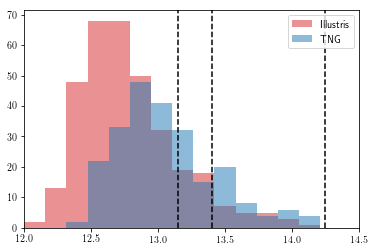

In [9]:
plt.hist(illustris_m_dm, bins=np.linspace(12,15,20), alpha=0.5, color=u'#d62728', label='Illustris')
plt.hist(tng_m_dm, bins=np.linspace(12,15,20), alpha=0.5, color=u'#1f77b4', label='TNG')

plt.xlim([12,14.5])

plt.axvline(mass_bins[1], linestyle='--', color='k')
plt.axvline(mass_bins[2], linestyle='--', color='k')
plt.axvline(mass_bins[3], linestyle='--', color='k')

plt.legend()
plt.show()

### HSC

In [10]:
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)

In [11]:
hsc_m_dm_sr = hsc_table['logmh_vir_symbol']
hsc_m_dm_rf = hsc_table['logmh_vir_forest']

hsc_m100 = hsc_table['logm_100']

In [12]:
hsc_table.keys()

['object_id',
 'ra',
 'dec',
 'clean_photometry',
 'z_spec',
 'z_best',
 'z_phot',
 'z_type',
 'gcmodel_mag',
 'gcmodel_mag_err',
 'rcmodel_mag',
 'rcmodel_mag_err',
 'icmodel_mag',
 'icmodel_mag_err',
 'zcmodel_mag',
 'zcmodel_mag_err',
 'ycmodel_mag',
 'ycmodel_mag_err',
 'MSTAR',
 'lum_max',
 'lum_150',
 'lum_120',
 'lum_100',
 'lum_75',
 'lum_50',
 'lum_25',
 'lum_10',
 'lum_5',
 'lum_15',
 'lum_30',
 'lum_40',
 'lum_60',
 'logm_5',
 'logm_10',
 'logm_15',
 'logm_25',
 'logm_30',
 'logm_40',
 'logm_50',
 'logm_60',
 'logm_75',
 'logm_100',
 'logm_120',
 'logm_150',
 'logm_max',
 'photoz_err68_min',
 'photoz_err68_max',
 'vdisp_sdss',
 'vdisp_err_sdss',
 'gama_id',
 'fluxscale_gama',
 'logms_gama',
 'logms_err_gama',
 'id_cluster_redm',
 'p_mem_redm',
 'z_lambda_redm',
 'z_lambda_err_redm',
 'lambda_redm',
 'lambda_err_redm',
 'p_cen_1_redm',
 'id_camira',
 'z_camira',
 'n_cor_camira',
 'logms_camira',
 'id_mem_camira',
 'w_mem_camira',
 'SFR',
 'AV',
 'TAU',
 'AGE',
 'ZMETAL',
 'r2

# plot M100, Mhalo

In [13]:
illustris_m100 = [m[5] for m in illustris_masses]
tng_m100 = [m[5] for m in tng_masses]

In [14]:
# #fit lines
# xs=np.linspace(12,15,100)

# illustris_lin_params = np.polyfit(illustris_m_dm, illustris_m100,1)
# illustris_line = np.poly1d(illustris_lin_params)

# tng_lin_params = np.polyfit(tng_m_dm, tng_m100,1)
# tng_line = np.poly1d(tng_lin_params)

# hsc_lin_params_sr = np.polyfit(hsc_m_dm_sr, hsc_m100,1)
# hsc_line_sr = np.poly1d(hsc_lin_params_sr)

# hsc_lin_params_rf = np.polyfit(hsc_m_dm_rf, hsc_m100,1)
# hsc_line_rf = np.poly1d(hsc_lin_params_rf)

In [124]:
def get_median(bins, x, y):
    dx = (bins[1] - bins[0])/2.
    bins_x = bins[1:]-dx
    
    x_y =np.vstack([x,y])
    
    bins_y=[]
    
    for i in range(len(bins)-1):
        l=bins[i]
        u=bins[i+1]
        
        mask = [(x_y[0]>l) & (x_y[0]<u)]

        y_in_range = x_y[1][mask]
        print len(y_in_range)
        bins_y.append(np.median(y_in_range))
        
    return bins_x, bins_y
               

In [126]:
n_bins=4
lower_bin = 12
upper_bin = 14.25
median_bins = np.linspace(lower_bin,upper_bin,n_bins+1)

bins_x_illustris, bins_y_illustris = get_median(median_bins, illustris_m_dm, illustris_m100)
bins_x_tng, bins_y_tng = get_median(median_bins, tng_m_dm, tng_m100)
bins_x_hsc, bins_y_hsc = get_median(median_bins, hsc_m_dm_sr, hsc_m100)

104
181
43
11
13
137
70
15
488
16248
7754
1223


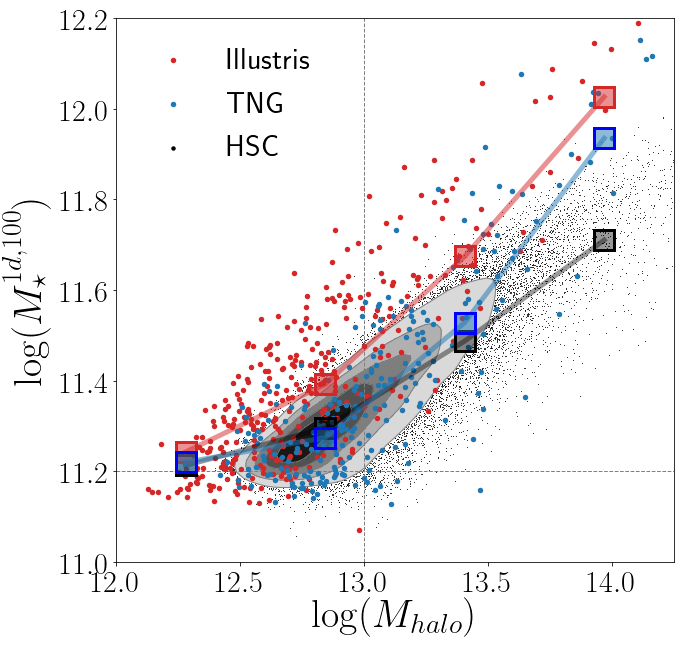

In [141]:
fig = plt.figure(figsize=[10,10])
plt.scatter(illustris_m_dm, illustris_m100, color=u'#d62728', label='Illustris', s=30, linewidth=0, zorder=5)
plt.scatter(tng_m_dm, tng_m100, color=u'#1f77b4', label='TNG', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_dm_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

# #linear fit
# plt.plot(xs, illustris_line(xs), c=u'#d62728', linewidth=3)
# plt.plot(xs, tng_line(xs), c=u'#1f77b4', linewidth=3)
# #plt.plot(xs, hsc_line_rf(xs), c='k', linestyle=':', label='HSC: random forest')
# plt.plot(xs, hsc_line_sr(xs), c='k', alpha=0.75, linestyle='-', linewidth=3)#, label='HSC: sybolic regression')

#plot medians
plt.plot(bins_x_illustris, bins_y_illustris, markersize=20, color=colorConverter.to_rgba(u'#d62728', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_tng, bins_y_tng, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)

#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{halo})$', fontsize=40)
plt.ylabel('$\log (M_{\star}^{1d, 100})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[2]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

# only hsc

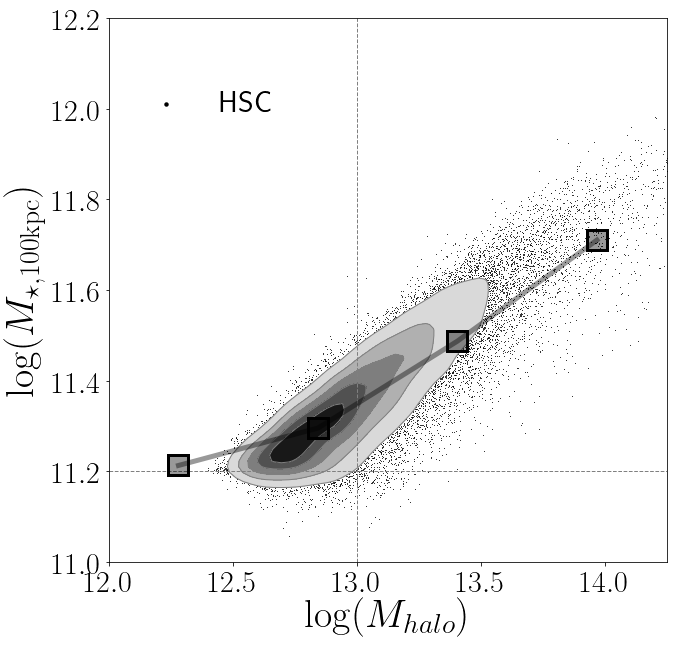

In [142]:
fig = plt.figure(figsize=[10,10])
#empty to move down legend
plt.scatter(tng_m_dm, tng_m100, color='w', label='.', s=0, linewidth=0, zorder=5)


#hsc
plt.scatter(hsc_m_dm_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

#plot medians
plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)



#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{halo})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False, loc='upper left')#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[1]._sizes = [20.]
lgnd.get_texts()[0].set_color("w")

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100a.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

### hsc+Illustris 

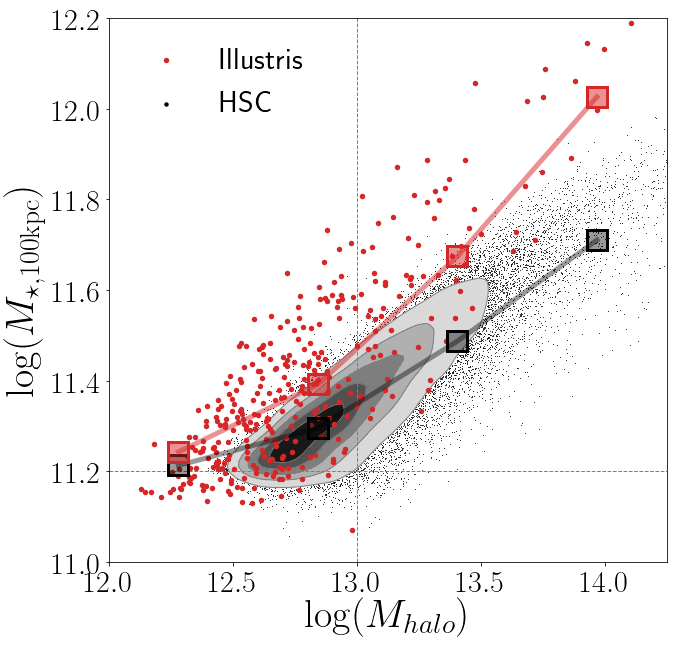

In [143]:
fig = plt.figure(figsize=[10,10])
plt.scatter(illustris_m_dm, illustris_m100, color=u'#d62728', label='Illustris', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_dm_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)

#plot medians
plt.plot(bins_x_illustris, bins_y_illustris, markersize=20, color=colorConverter.to_rgba(u'#d62728', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)

#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{halo})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False, loc='upper left')#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[1]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100b.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

### hsc+tng

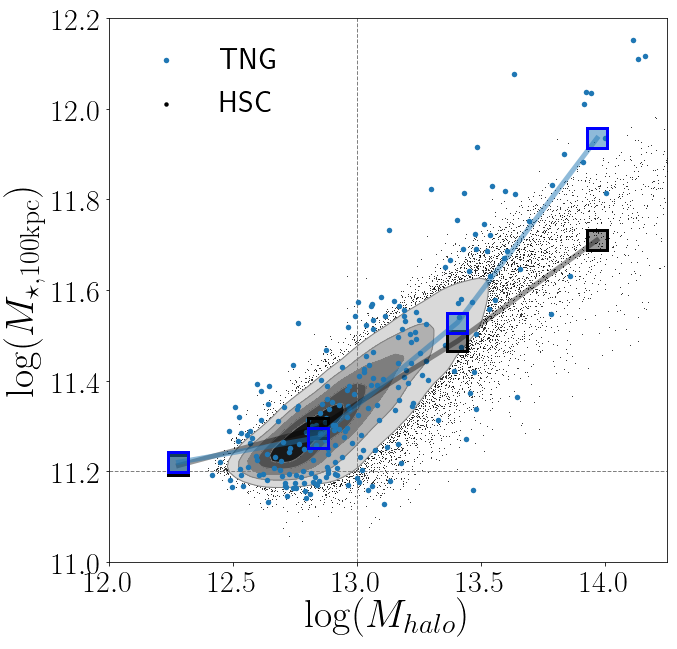

In [144]:
fig = plt.figure(figsize=[10,10])
plt.scatter(tng_m_dm, tng_m100, color=u'#1f77b4', label='TNG', s=30, linewidth=0, zorder=5)

#hsc
plt.scatter(hsc_m_dm_sr, hsc_m100, marker='o', color='k', label='HSC', s=1, linewidth=0, alpha=1, zorder=0)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7, zorder =1)
sns.kdeplot(hsc_m_dm_sr, hsc_m100, colors='grey', cmap=None, shade_lowest=False,  n_levels=7, linewidths=1)


#plot medians
plt.plot(bins_x_tng, bins_y_tng, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
         linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1), 
         markeredgewidth=3)
plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
         linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
         markeredgewidth=3)


#make cut to include M_100>11.5
plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{halo})$', fontsize=40)
plt.ylabel('$\log (M_{\star, 100\mathrm{kpc}})$', fontsize=40)

plt.tick_params(axis='both', which='major', labelsize=30)

plt.xlim([12,14.25])
plt.ylim([11,12.2])


#legend
lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False, loc='upper left')#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
#change the marker size manually for both lines
lgnd.legendHandles[1]._sizes = [20.]

fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M100c.pdf',
            dpi=100, format='pdf', bbox_inches='tight')



plt.show()

## compare both hsc massses

In [28]:
hsc_lin_params1 = np.polyfit(hsc_m_dm_sr, hsc_m100,1)
hsc_line1 = np.poly1d(hsc_lin_params1)

hsc_lin_params2 = np.polyfit(hsc_m_dm_rf, hsc_m100,1)
hsc_line2 = np.poly1d(hsc_lin_params2)

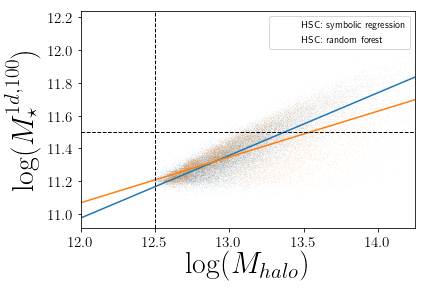

In [29]:
plt.scatter(hsc_m_dm_sr, hsc_m100, label='HSC: symbolic regression', s=1, linewidth=0, alpha=0.05, zorder=1)
plt.scatter(hsc_m_dm_rf, hsc_m100, label='HSC: random forest', s=1, linewidth=0, alpha=0.05, zorder=1)

#linear fit
plt.plot(xs, hsc_line1(xs))
plt.plot(xs, hsc_line2(xs))

#make cut to include M_100>11.5
plt.axhline(11.5, c='k', linewidth=1, linestyle='--')
plt.axvline(12.5, c='k', linewidth=1, linestyle='--')

plt.xlabel('$\log (M_{halo})$', fontsize=30)
plt.ylabel('$\log (M_{\star}^{1d, 100})$', fontsize=30)

plt.tick_params(axis='both', which='major', labelsize=15)

plt.xlim([12,14.25])

plt.legend(fontsize=10)
plt.show()

### M_halo > 13 

In [42]:
illustris_m_dm_cut = illustris_m_dm[illustris_m_dm>13]
tng_m_dm_cut = tng_m_dm[tng_m_dm>13]

In [43]:
#function to count number of galaxies in each mass bin
def num_gals(masses, mass_bins):
    n_bins = len(mass_bins) - 1
    
    gals_per_bin=[]
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        gals = masses[(masses>lower) & (masses<upper)]
        
        gals_per_bin.append(len(gals))
        
    return gals_per_bin

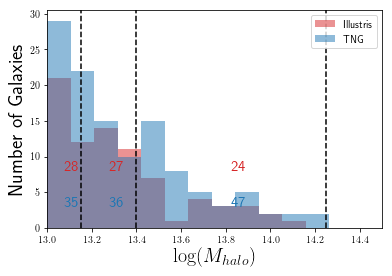

In [44]:
plt.hist(illustris_m_dm_cut, bins=np.linspace(13,15,20), alpha=0.5, color=u'#d62728', label='Illustris')
plt.hist(tng_m_dm_cut, bins=np.linspace(13,15,20), alpha=0.5, color=u'#1f77b4', label='TNG')

plt.xlim([13,14.5])

#number in each mass bin
tng_n_per_bin = num_gals(tng_m_dm , mass_bins )
illustris_n_per_bin = num_gals(illustris_m_dm , mass_bins )
for i in range(len(tng_n_per_bin)):
    plt.text(np.mean(mass_bins[i:i+2]), 8, str(illustris_n_per_bin[i]), fontsize=15, color=u'#d62728')
    plt.text(np.mean(mass_bins[i:i+2]), 3, str(tng_n_per_bin[i]), fontsize=15, color=u'#1f77b4')
    
    plt.axvline(mass_bins[i+1], linestyle='--', color='k')
    

plt.legend(loc='upper right')

plt.xlabel('$\log (M_{halo})$', fontsize=20)
plt.ylabel('Number of Galaxies', fontsize=20)
plt.show()

# Surface brightness profiles

## get HSC profiles in each mass bin 

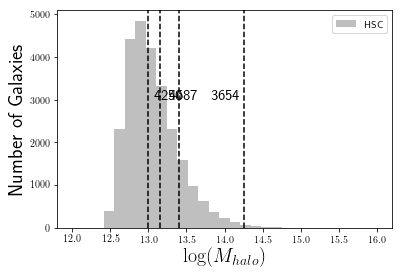

In [59]:
plt.hist(hsc_table['logmh_vir_symbol'], bins=np.linspace(12,16,30), alpha=0.5, color='grey', label='HSC')

#plt.xlim([13,14.5])

#number in each mass bin
hsc_n_per_bin = num_gals(hsc_table['logmh_vir_symbol'] , mass_bins)

plt.axvline(mass_bins[0], linestyle='--', color='k')

for i in range(len(tng_n_per_bin)):
    plt.text(np.mean(mass_bins[i:i+2]), 3000, str(hsc_n_per_bin[i]), fontsize=15, color='k')
    
    plt.axvline(mass_bins[i+1], linestyle='--', color='k')
    

plt.legend(loc='upper right')

plt.xlabel('$\log (M_{halo})$', fontsize=20)
plt.ylabel('Number of Galaxies', fontsize=20)
plt.show()

In [45]:
def hsc_profiles_in_bin(hsc_gals, mass_bins):
    n_bins = len(mass_bins) - 1
    
    profiles_in_bins=[]
    
    for bin in range(n_bins):
        lower = mass_bins[bin]
        upper = mass_bins[bin+1]
        
        sbps = hsc_gals['sbp'][(hsc_gals['logmh_vir_symbol']>lower) & (hsc_gals['logmh_vir_symbol']<upper)]
        
        profiles_in_bins.append(sbps)
        
    return profiles_in_bins

In [46]:
hsc_profiles = hsc_profiles_in_bin(hsc_table, mass_bins)
hsc_sma = np.arange(0.4, 4.2, 0.01)

## Illustris 

In [47]:
#mass range 1
illustris_isos1=[]
ngals1=0

#mass range 2
illustris_isos2=[]
ngals2=0

#mass range 3
illustris_isos3=[]
ngals3=0

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


28 27 24


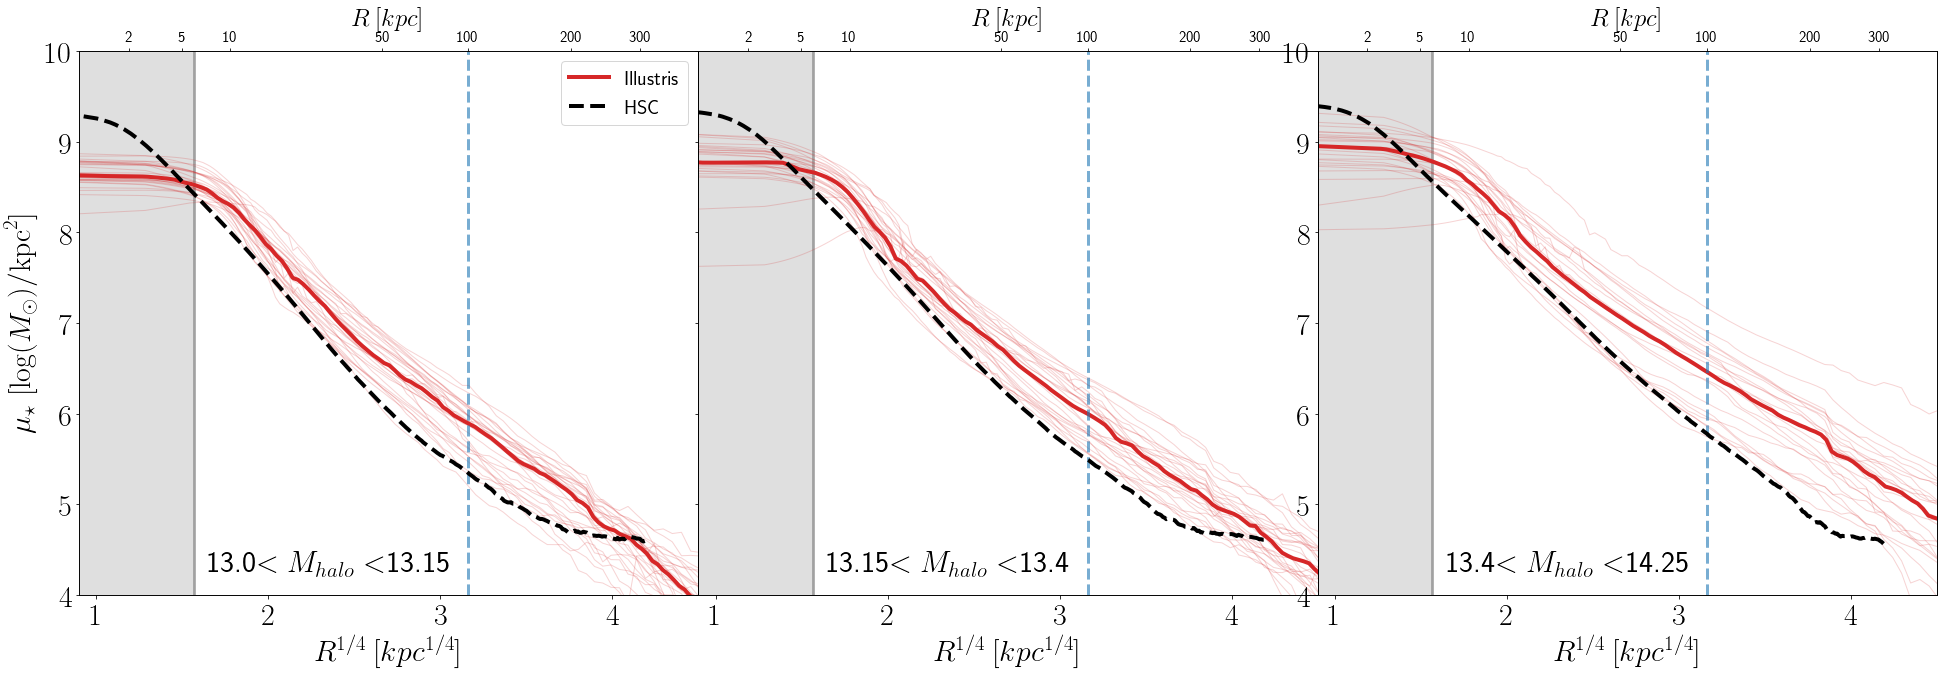

In [48]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(10*3, 10))
# fig.subplots_adjust(left=0.22, right=0.995, bottom=0.14, top=0.94, wspace=0.00, hspace=0.00)
fig=plt.figure(figsize=(10*6, 10))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.0)
ax3 = plt.subplot(gs2[0, -1])


######################################################################################################################
# plot
######################################################################################################################
#hsc
# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
  


for mass, iso in zip(illustris_m_dm, illustris_isos): 
    
    if (mass<mass_bins[0]) or (mass>mass_bins[-1]):
        continue

    elif (mass>=mass_bins[0]) and (mass<mass_bins[1]):
        ngals1+=1

        illustris_isos1.append(iso)

        ax1.plot((iso['sma'] * pixel_scale) ** 0.25,
             np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0) , linewidth=1.0, c=u'#d62728', alpha=0.2, 
                 label='_nolegend_')
                 #label='illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
            
        
    elif (mass>=mass_bins[1]) and (mass<mass_bins[2]):
        ngals2+=1
        
        illustris_isos2.append(iso)

        ax2.plot((iso['sma'] * pixel_scale) ** 0.25,
             np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#d62728', alpha=0.2, 
                 label='_nolegend_')
                 #label='illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
    
    elif (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        ngals3+=1
        
        illustris_isos3.append(iso)

        ax3.plot((iso['sma'] * pixel_scale) ** 0.25,
             np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#d62728', alpha=0.2, 
                 label='_nolegend_')
                 #label='illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


        
## median profiles for illustris
median_sma1, median_mu1 = get_median_profile(illustris_isos1, pixel_scale = pixel_scale)
median_sma2, median_mu2 = get_median_profile(illustris_isos2, pixel_scale = pixel_scale)
median_sma3, median_mu3 = get_median_profile(illustris_isos3, pixel_scale = pixel_scale)

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')
ax2.plot(median_sma2, median_mu2+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')
ax3.plot(median_sma3, median_mu3+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')



print ngals1, ngals2, ngals3


####################################################################################################################
#plot HSC profiles
# for profile in hsc_profiles[0]:
#     ax1.plot(hsc_sma, profile, linewidth=0.5, c='grey',
#          alpha=0.1, zorder=8, label='HSC')

#medians
ax1.plot(hsc_sma, np.nanmedian(hsc_profiles[0], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
ax2.plot(hsc_sma, np.nanmedian(hsc_profiles[1], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
ax3.plot(hsc_sma, np.nanmedian(hsc_profiles[2], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
    
######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)
ax3.set_xlim(0.9, 4.5)
ax3.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='x', which='major', labelsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.65, 4.2, str(mass_bins[0]) + '$< M_{halo} <$' + str(mass_bins[1]), size=30)
ax2.text(1.65, 4.2, str(mass_bins[1]) + '$< M_{halo} <$' + str(mass_bins[2]), size=30)
ax3.text(1.65, 4.2, str(mass_bins[2]) + '$< M_{halo} <$' + str(mass_bins[3]), size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=15)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax3_twin.tick_params(axis='both', which='major', labelsize=15)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax3.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
#ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)

######################################################################################################################
#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax3.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

# TNG 

In [49]:
#mass range 1
tng_isos1=[]
ngals1=0

#mass range 2
tng_isos2=[]
ngals2=0

#mass range 3
tng_isos3=[]
ngals3=0

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


35 36 47


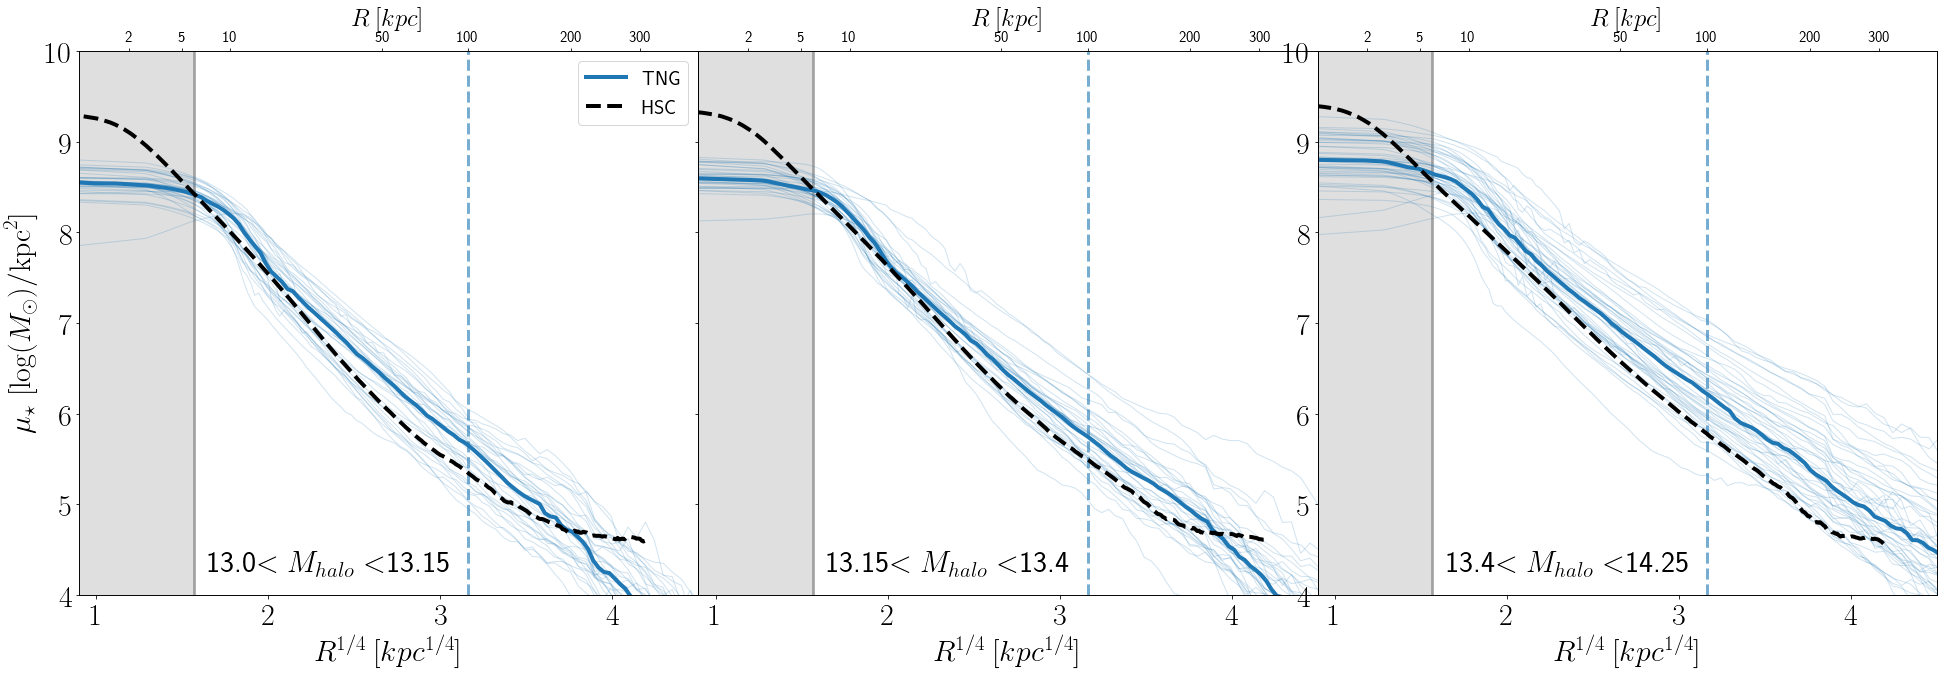

In [50]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=False, figsize=(10*3, 10))
# fig.subplots_adjust(left=0.22, right=0.995, bottom=0.14, top=0.94, wspace=0.00, hspace=0.00)
fig=plt.figure(figsize=(10*6, 10))
gs1 = gridspec.GridSpec(1, 3)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.0)
ax3 = plt.subplot(gs2[0, -1])


######################################################################################################################
# plot
######################################################################################################################
#hsc
# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
  


for mass, iso in zip(tng_m_dm, tng_isos): 
    
    if (mass<mass_bins[0]) or (mass>mass_bins[-1]):
        continue

    elif (mass>=mass_bins[0]) and (mass<mass_bins[1]):
        ngals1+=1

        tng_isos1.append(iso)

        ax1.plot((iso['sma'] * pixel_scale) ** 0.25,
             np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0) , linewidth=1.0, c=u'#1f77b4', alpha=0.2, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
            
        
    elif (mass>=mass_bins[1]) and (mass<mass_bins[2]):
        ngals2+=1
        
        tng_isos2.append(iso)

        ax2.plot((iso['sma'] * pixel_scale) ** 0.25,
             np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#1f77b4', alpha=0.2, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))
    
    elif (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        ngals3+=1
        
        tng_isos3.append(iso)

        ax3.plot((iso['sma'] * pixel_scale) ** 0.25,
             np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#1f77b4', alpha=0.2, 
                 label='_nolegend_')
                 #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


        
## median profiles for tng
median_sma1, median_mu1 = get_median_profile(tng_isos1, pixel_scale = pixel_scale)
median_sma2, median_mu2 = get_median_profile(tng_isos2, pixel_scale = pixel_scale)
median_sma3, median_mu3 = get_median_profile(tng_isos3, pixel_scale = pixel_scale)

ax1.plot(median_sma1, median_mu1+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG')
ax2.plot(median_sma2, median_mu2+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG')
ax3.plot(median_sma3, median_mu3+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG')



print ngals1, ngals2, ngals3

####################################################################################################################
#plot HSC profiles
# for profile in hsc_profiles[0]:
#     ax1.plot(hsc_sma, profile, linewidth=0.5, c='grey',
#          alpha=0.1, zorder=8, label='HSC')

#medians
ax1.plot(hsc_sma, np.nanmedian(hsc_profiles[0], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
ax2.plot(hsc_sma, np.nanmedian(hsc_profiles[1], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
ax3.plot(hsc_sma, np.nanmedian(hsc_profiles[2], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
    

######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)
ax3.set_xlim(0.9, 4.5)
ax3.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='x', which='major', labelsize=30)
ax3.tick_params(axis='both', which='major', labelsize=30)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.65, 4.2, str(mass_bins[0]) + '$< M_{halo} <$' + str(mass_bins[1]), size=30)
ax2.text(1.65, 4.2, str(mass_bins[1]) + '$< M_{halo} <$' + str(mass_bins[2]), size=30)
ax3.text(1.65, 4.2, str(mass_bins[2]) + '$< M_{halo} <$' + str(mass_bins[3]), size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=15)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

x1, x2 = ax3.get_xlim()
ax3_twin = ax3.twiny()
ax3_twin.set_xlim(x1, x2)
ax3_twin.figure.canvas.draw()
ax3_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax3_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax3_twin.tick_params(axis='both', which='major', labelsize=15)
ax3_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax3.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
#ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax3.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax3.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)

######################################################################################################################
#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax3.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_TNG.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

# Plot for Alexie's talk

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in log10


22 42


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


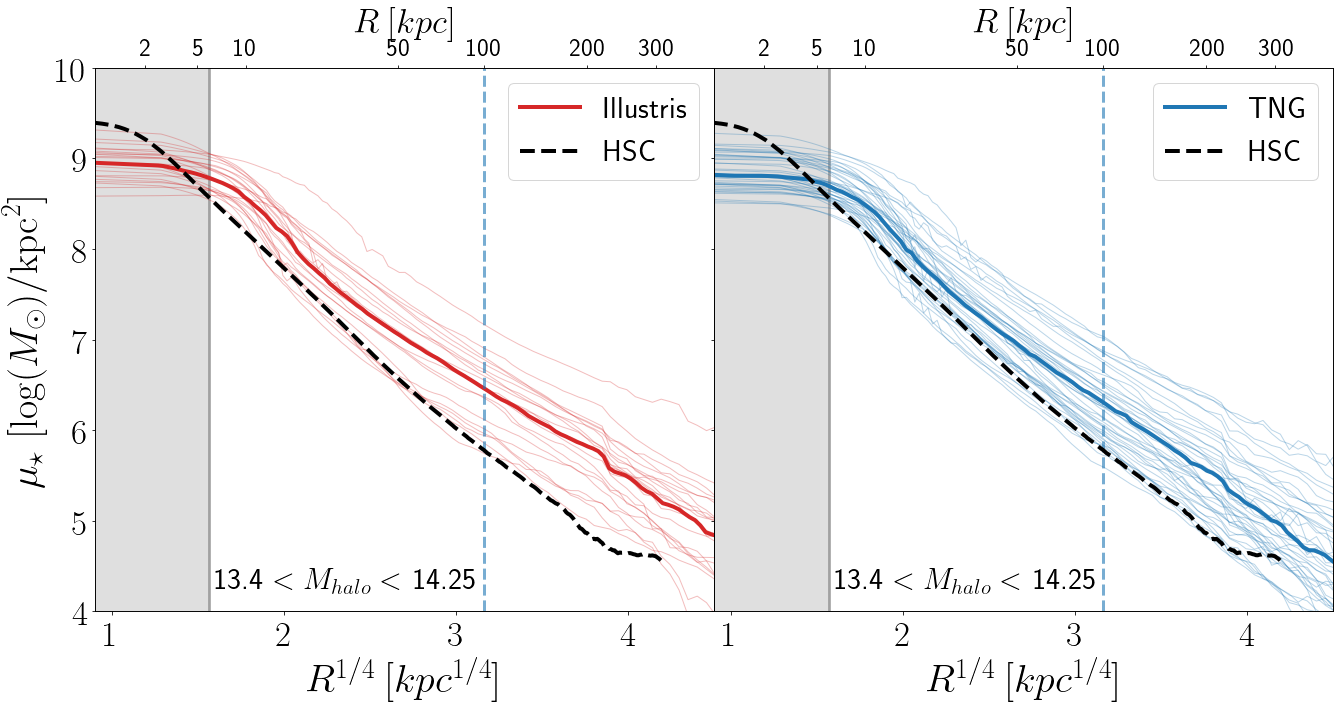

In [71]:
ngals_illustris, ngals_tng = 0,0

fig=plt.figure(figsize=(10*4, 10))
gs1 = gridspec.GridSpec(1, 2)
gs1.update(left=0.05, right=0.48, wspace=0.0)
ax1 = plt.subplot(gs1[0, 0])
ax2 = plt.subplot(gs1[0, 1])
gs2 = gridspec.GridSpec(1, 3)
gs2.update(left=0.05, right=0.48, wspace=0.0)


######################################################################################################################
# plot
######################################################################################################################
#hsc
# ax1.plot(RSMA_COMMON, hscMedProf_116_118, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
# ax2.plot(RSMA_COMMON, hscMedProf_118_120, linestyle='--', linewidth=4.0, c='k',
#          alpha=1, zorder=8, label='HSC')
  
for mass, iso in zip(illustris_m_dm, illustris_isos): 
    

    if (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        sma = (iso['sma'] * pixel_scale) ** 0.25
        mu = np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0)
        
        if np.interp(1, sma, mu) > 8.5 :
            ngals_illustris+=1

            tng_isos3.append(iso)

            ax1.plot((iso['sma'] * pixel_scale) ** 0.25,
                 np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#d62728', alpha=0.3, 
                     label='_nolegend_')
                     #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


        

for mass, iso in zip(tng_m_dm, tng_isos): 
    

    if (mass>=mass_bins[2]) and (mass<mass_bins[3]):
        sma = (iso['sma'] * pixel_scale) ** 0.25
        mu = np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0)
        
        if np.interp(1, sma, mu) > 8.5 :
            ngals_tng+=1

            tng_isos3.append(iso)

            ax2.plot((iso['sma'] * pixel_scale) ** 0.25,
                 np.log10(iso['intens'] / (pixel_scale**2))+ np.log10(0.7 ** 2.0), linewidth=1.0, c=u'#1f77b4', alpha=0.3, 
                     label='_nolegend_')
                     #label='tng Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))

print ngals_illustris, ngals_tng
        
## median profiles for tng
median_sma_illustris, median_mu_illustris = get_median_profile(illustris_isos3, pixel_scale = pixel_scale)
median_sma_tng, median_mu_tng = get_median_profile(tng_isos3, pixel_scale = pixel_scale)

ax1.plot(median_sma_illustris, median_mu_illustris+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris')
ax2.plot(median_sma_tng, median_mu_tng+ np.log10(0.7 ** 2.0), linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG')


####################################################################################################################
#plot HSC profiles
# for profile in hsc_profiles[0]:
#     ax1.plot(hsc_sma, profile, linewidth=0.5, c='grey',
#          alpha=0.1, zorder=8, label='HSC')

#medians
ax1.plot(hsc_sma, np.nanmedian(hsc_profiles[2], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')
ax2.plot(hsc_sma, np.nanmedian(hsc_profiles[2], axis=0), linestyle='--', 
         linewidth=4.0, c='k', alpha=1, zorder=8, label='HSC')

######################################################################################################################
# plot details
######################################################################################################################
# # X-Y limits
ax1.set_xlim(0.9, 4.5)
ax1.set_ylim(4, 10)
ax2.set_xlim(0.9, 4.5)
ax2.set_ylim(4, 10)

# Labels
# ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
#                size=60)
# ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
#                size=60)
ax1.tick_params(axis='both', which='major', labelsize=35)
ax2.tick_params(axis='x', which='major', labelsize=35)

# #ax1.text(11.8, -3.7, r'$\mathrm{Normalized}$', size=60)
# ax1.axvline(11.6, linestyle='--', linewidth=4.0, alpha=0.8, zorder=0)

#text label
ax1.text(1.6, 4.2, str(mass_bins[2]) + ' $ < M_{halo} < $ ' + str(mass_bins[3]), size=30)
ax2.text(1.6, 4.2, str(mass_bins[2]) + ' $ < M_{halo} < $ ' + str(mass_bins[3]), size=30)

ax1.legend(fontsize=30)
ax2.legend(fontsize=30)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax1_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax1_twin.tick_params(axis='both', which='major', labelsize=25)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=35)

x1, x2 = ax2.get_xlim()
ax2_twin = ax2.twiny()
ax2_twin.set_xlim(x1, x2)
ax2_twin.figure.canvas.draw()
ax2_twin.xaxis.set_ticks([2**0.25, 5**0.25, 10**0.25, 50**0.25, 100**0.25, 200**0.25, 300**0.25])
ax2_twin.xaxis.set_ticklabels([2, 5, 10, 50, 100, 200, 300])
ax2_twin.tick_params(axis='both', which='major', labelsize=25)
ax2_twin.set_xlabel(r'$R \: [kpc]$', fontsize=35)


######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
ax2.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=40)
#ax3.set_ylabel(r'$M_{\star}( < r ) \: [ \log (M_{\odot})]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=40)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)
ax2.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax2.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='grey', zorder=1)

######################################################################################################################
#grey out psf region
ax1.axvspan(0, 6**0.25, alpha=0.25, color='grey')
ax2.axvspan(0, 6**0.25, alpha=0.25, color='grey')
######################################################################################################################
#adjustments to ticks and space between subplots

#plt.setp([a.get_yticklabels() for a in fig.axes[1:]], visible=False)
plt.setp(ax2.get_yticklabels(), visible=False)
#plt.setp(ax2.get_xticklabels()[0], visible=False)

#remove last label in x-axis of ax1 to prevent overlaping of labels with ax2
labels1 = [item.get_text() for item in ax2.get_xticklabels()[:-1]]
ax1.set_xticklabels(labels1)

#add a bit of space between subplots
# plt.tight_layout()

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_TNG.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')


plt.show()